# **AutoDiff**
Automatic differentiation is useful for implementing machine learning algorithms such as backpropagation for training neural networks.

#### **Setup**

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as pl

#### **Computing Gradients**
TensorFlow uses GradientTape function to compute the Gradients (loss fn, other values)

#### **Gradient Tapes**

In [24]:
# Define a function for comoutation
def fn(x_ten):
    return x_ten**2

x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    # Use defined function to transform the input.
    y = fn(x)

# Use GradientTape() to compute gradient... 
tape.gradient(y, x).numpy()

6.0

In [ ]:
### Gradients with nd-Variables
v1 = tf.Variable(tf.random.normal([3,3], 3, 9,seed= 3, name= 'var1'))
v2 = tf.Variable(tf.eye(3), name='var2')

w = [[1. ,2. ,3. ]]

# Recording operations onto `tape`
with tf.GradientTape() as tape:
    y = v1 * w + v2
    loss = tf.reduce_mean(y**2)
    
# Computing gradients w.r.t...


> **Using a dictionary of Variables with the same tape as above**

In [ ]:
(dl_dv1, dl_dv2) = tape.gradient(loss, [v1, v2])
  
# np.argsort organizes the index bsaed on the sorted order of the tensor.
np.argsort(tf.nn.softmax(dl_dv1.numpy()))
dl_dv2.numpy()



In [42]:
my_vars = {
    'dl_dw': v1,
    'dl_db': v2
}

grad = tape.gradient(loss, my_vars)

for i in grad:
    print(f'The name of the tensor-Variable is: {i}')
    print(grad[i].numpy())
    print()

np.argsort(tf.nn.softmax(grad['dl_db']).numpy())

# We discovered a new problem here...  
# If this problem occurs 
# 'A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)'
# It means the tape has previously been used to compute the gradients, thus it can not be reused.




{'dl_dw': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[  0.5811825 , -10.723121  ,   6.628027  ],
       [  2.0538814 ,   8.9651165 ,  38.633232  ],
       [  3.0487926 ,   0.34223557, -26.612106  ]], dtype=float32)>, 'dl_db': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.5811825 , -5.3615603 ,  2.2093422 ],
       [ 2.0538814 ,  4.4825583 , 12.877744  ],
       [ 3.0487926 ,  0.17111778, -8.870702  ]], dtype=float32)>}


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.5811825 , -5.3615603 ,  2.2093422 ],
       [ 2.0538814 ,  4.4825583 , 12.877744  ],
       [ 3.0487926 ,  0.17111778, -8.870702  ]], dtype=float32)>

#### **Model Gradients**

In [79]:
import tensorflow.keras.layers as lyrs
import tensorflow.keras.activations as act

D_layer = lyrs.Dense(32, activation= act.relu)
x_ten = tf.cast(tf.linspace([1,5], [10, -4], 10), tf.float16)
x_ten

with tf.GradientTape() as tape2:
    y = D_layer(x_ten)
    loss = tf.reduce_mean(y ** 2)
# Computing the gradient    
grad = tape2.gradient(loss, D_layer.trainable_variables)

# Displaying the Output
tf.nn.softmax(grad[0]).numpy()
np.argmax(tf.nn.softmax(grad[0]).numpy())


8

In [80]:
for var, g in zip(D_layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')


dense_23/kernel:0, shape: (2, 32)
dense_23/bias:0, shape: (32,)


#### **Controlling what the tape watches**
> The default behavior is to record all operations after accessing a **`trainable tf.Variable`**.

> Tape cannot compute gradients for tesnors as thet're immutables

In [86]:
# The only trainable Variable
var1 = tf.Variable(3.0)
# Non-trainanle
var2 = tf.Variable(5.0, trainable= False)

# A constant tensor (no grads for tensors)
ten1 = tf.constant(5.0)
# Variable + constant = constant, thus below is also a tensor
ten2 = tf.Variable(10.0) + 3.0

with tf.GradientTape() as tape3:
    y = (var1**2) + (var2**2) + (ten1**2) + ten2

grads = tape3.gradient(y, [var1, var2, ten1, ten2])

for gr in grads:
    print(gr)


tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


List Variables watched by the tape

In [93]:
print([var for var in tape3.watched_variables()])
[var.name for var in tape3.watched_variables()]


[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>]


['Variable:0']

> **To record gradients with respect to a tf.Tensor, you need to call `GradientTape.watch(x)`**

In [120]:
rten = tf.random.uniform([3, 3], 0, 20, seed= 3)

tf.transpose(rten)

with tf.GradientTape() as ten_tape:
    ten_tape.watch(rten)
    y = rten @ (tf.transpose(rten) *  tf.random.normal([3, 3], 10, 5))

dy_dx = ten_tape.gradient(y, rten)
print(dy_dx)
print(tf.nn.softmax(dy_dx))
print(np.argmax(tf.nn.softmax(dy_dx)))


tf.Tensor(
[[842.26544 154.64954 706.1339 ]
 [926.0429  298.74033 326.2389 ]
 [845.9513  426.66037 588.9402 ]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]], shape=(3, 3), dtype=float32)
0


> **To disable default behaviuor of Gradient-Tape, use `watch_accessed_variables=False` paramater**

In [134]:
v1 = tf.Variable(31.4, name= 'var1')
v2 = tf.Variable(21.7, name= 'var2')

with tf.GradientTape(watch_accessed_variables= False) as gt:
    gt.watch(v2)
    y = v1**2 + v2**2

vars = {
    'Variable1' : v1,
    'Variable2' : v2
}

grz = gt.gradient(y, vars)

print("Printing Gradients for each variable")
for gr in grz:
    print(gr)
    print(grz[gr])
    print()


# Printing all watched variables
print([var for var in gt.watched_variables()])
print("This shows that only var2 is being watched")

Printing Gradients for each variable
Variable1
None

Variable2
tf.Tensor(43.4, shape=(), dtype=float32)

[<tf.Variable 'var2:0' shape=() dtype=float32, numpy=21.7>]
This shows that only var2 is being watched


#### **Intermediate Results**

In [4]:
xten = tf.constant([1, 3.2, 5.4])

with tf.GradientTape() as gt:
    gt.watch(xten)
    y = xten ** 2
    z = y * xten

gt.gradient(z, y).numpy() 

array([1. , 3.2, 5.4], dtype=float32)

In [26]:
ten1 = tf.cast(tf.linspace(5.5, 72.8, 18), tf.float32)
ten1 = tf.reshape(ten1, shape=(3,3 , -1))
print("This is the main array\n", ten1.numpy())

def f(x):
    return tf.nn.log_softmax(x) * 1.5 * tf.random.normal(shape=[3,3,2], mean=0, stddev= 5)

def g(x):
    return tf.tanh(x) ** 2

with tf.GradientTape(persistent= True) as tx:
    tx.watch(ten1)
    y1 = f(ten1)
    y2 = g(y1)

print()    
print(tx.gradient(y1, ten1).numpy())
print()

print()
print(tx.gradient(y2, y1).numpy())

print()
print(tx.gradient(y2, ten1).numpy())


This is the main array
 [[[ 5.5       9.458824]
  [13.417647 17.37647 ]
  [21.335295 25.294119]]

 [[29.252941 33.211765]
  [37.17059  41.129414]
  [45.088238 49.047062]]

 [[53.005882 56.964706]
  [60.92353  64.882355]
  [68.84118  72.8     ]]]

[[[-5.39861    5.39861  ]
  [ 9.724726  -9.724726 ]
  [ 7.136075  -7.136075 ]]

 [[-3.386214   3.3862143]
  [ 1.8387884 -1.8387884]
  [ 0.5631099 -0.5631094]]

 [[-3.006029   3.0060282]
  [ 5.3085713 -5.3085713]
  [ 8.977145  -8.977145 ]]]

[[[ 0.0000000e+00 -2.8246850e-01]
  [-0.0000000e+00  6.2194556e-02]
  [-0.0000000e+00 -6.5302171e-02]]

 [[ 0.0000000e+00 -2.8457141e-01]
  [-2.1457661e-06 -4.3686420e-02]
  [-2.6601760e-02 -2.7351511e-01]]

 [[ 0.0000000e+00  2.9256722e-01]
  [-0.0000000e+00  2.7639383e-01]
  [-0.0000000e+00  2.7315727e-02]]]

[[[ 0.04064255 -0.0406425 ]
  [ 0.0019184  -0.0019184 ]
  [ 0.00211517 -0.00211518]]

 [[ 0.0412682  -0.04126835]
  [ 0.0009419  -0.0009419 ]
  [ 0.01935778 -0.01935792]]

 [[ 0.04369489 -0.04369497]

#### **Note on Performance**

In [ ]:
## There is a tiny overhead associated with doing operations inside a gradient tape context. 
#  For most eager execution this will not be a noticeable cost, but you should still use 
#  tape context around the areas only where it is required.

## Gradient tapes use memory to store intermediate results, including inputs and outputs, 
#  for use during the backwards pass.



#### **Gradients of non-scalar targets**
> **MultiGradients**

In [16]:
x = tf.constant([1., 4., 9.])

with tf.GradientTape(persistent=True) as gt:
    gt.watch(x)
    y1 = x * x
    y2 = 1 / y1

# Comuting Individual gradients...
g1 = gt.gradient(y1 ,x)
g2 = gt.gradient(y2, x)

print(f'Gradient(dy1_dx): {g1}')
print(f'Gradient(dy2_dx): {g2}')

g_com = gt.gradient({'g1': y1, 'g2': y2}, x)

print("Composite Gradients")
print(g_com.numpy())

###  Computing the gradient of multiple targets, the result for each source is:
#       The gradient of the sum of the targets, or equivalently
#       The sum of the gradients of each target.
del gt


Gradient(dy1_dx): [ 2.  8. 18.]
Gradient(dy2_dx): [-2.         -0.03125    -0.00274348]
Composite Gradients


In [22]:
## If the target(s) are not scalar the gradient of the sum is calculated
x = tf.Variable(2.0)

with tf.GradientTape() as gt:
    y = x * [3. , 4.]

gt.gradient(y, x).numpy()

del gt

 > **For an element-wise calculation, the gradient of the sum gives the derivative of each element with respect to its input-element, since each element is independent**

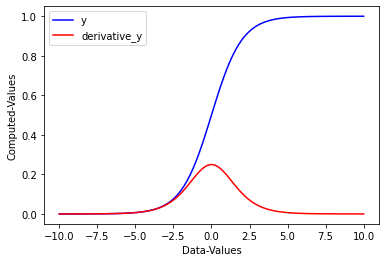

In [28]:
x = tf.linspace(-10, 10, 101)
x.numpy()

with tf.GradientTape() as gt:
    gt.watch(x)
    y = tf.nn.sigmoid(x)
    
der = gt.gradient(y, x)
der 

pl.plot(x, y, 'b', label= 'y')
pl.plot(x, der, 'r', label= 'derivative_y')
pl.xlabel('Data-Values')
pl.ylabel('Computed-Values')
pl.legend()
pl.show()

del gt


#### **Control Flow**
> How the gradients are computed incase of branched operations within the GradientTape (`if/else, loops`)

In [ ]:
# Because a gradient tape records operations as they are executed, 
# Python control flow is naturally handled

x = 0

v1 = tf.Variable(3.)
v2 = tf.Variable([2.5, -2.5])

with tf.GradientTape() as gt:
    for i in range(3):
        if x == 0:
            y1 = v1**2
            x = 1
        else:
            y1 = v2 / v1
            x = 0

[g1, g2] = gt.gradient(y1, [v1, v2])
print(g1.numpy())
print(g2)

del gt
            

6.0
None


In [33]:
# Because a gradient tape records operations as they are executed, 
# Python control flow is naturally handled

x = 0

v1 = tf.Variable(3.)
v2 = tf.Variable([2.5, -2.5])

with tf.GradientTape() as gt:
    for i in range(3):
        if x == 0:
            y1 = v1**2
            x = 1
        else:
            y1 = v2 / v1
            x = 0

[g1, g2] = gt.gradient(y1, [v1, v2])
print(g1.numpy())
print(g2)

del gt
            

6.0
None


#### **Getting Gradient of None**

> ##### **When a target is not connected to a source you will get a gradient of None.**

In [37]:
x1 = tf.constant(2.)
x2 = tf.constant(4.)

with tf.GradientTape() as gt:
    y = tf.tanh(x1)

print(gt.gradient(y, x2)) 


None


> ##### **Replaced Variable with Tensor**

In [76]:
# One common error is to inadvertently replace a tf.Variable with a tf.Tensor, 
# instead of using Variable.assign to update the tf.Variable.
# Eaxmple
x = tf.Variable(4.0)
with tf.GradientTape() as gt:
    y = 0
    for epochs in range(3):
        y = tf.nn.sigmoid(x)
        print(f'type of x {type(x).__name__}')
    
    x.assign_add(1.5) # Correct syntax
    x = x + 1 # Here, x converts to a tensor

    print(f'type of x {type(x).__name__}')

g = gt.gradient(y, x)
print(g)

del gt


type of x ResourceVariable
type of x ResourceVariable
type of x ResourceVariable
type of x EagerTensor
tf.Tensor(0.0, shape=(), dtype=float32)


> ##### **Working with Varibles out of TensorFlow**

In [52]:
x = tf.Variable([
    [5,6,8,3,5],
    [9,8,7,1,34]
], dtype=tf.float32)

with tf.GradientTape() as gt:
    y = x*2
    
    y = np.mean(y, axis=0) # Numpy calculation
    
    y = tf.reduce_mean(y, axis= 0)

print(gt.gradient(y, x))
del gt

None


> ##### **Gradients of an int or string is None**

In [58]:
x = tf.constant(10)
with tf.GradientTape() as gt:
    gt.watch(x)
    y = tf.transpose(x)

print(gt.gradient(y,x))
del gt


None


> ##### **Taking Gradients through a stateful object**

In [61]:
## State stops gradients. When you read from a stateful object, the tape can only observe 
#  the current state, not the history that lead to it.

## A tf.Variable has internal state—its value. When you use the variable, the state is read. 
#  It's normal to calculate a gradient with respect to a variable, but the variable's state 
#  blocks gradient calculations from going farther back.

a = tf.Variable(1.0)
b = tf.Variable(3.0)

with tf.GradientTape() as gt:
    # The state of the Variable changes here
    b.assign_sub(a)
    # Tape Starts recording here
    y = b * 2
    y = y / a
    
d1, d2 = gt.gradient(y, [a,b])
d1, d2    

# For some reason, I'm not getting a `None` gradient

(<tf.Tensor: shape=(), dtype=float32, numpy=-4.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>)

In [ ]:
# One common error is to inadvertently replace a tf.Variable with a tf.Tensor, 
# instead of using Variable.assign to update the tf.Variable.

# Eaxmple
x = tf.Variable(4.0)
with tf.GradientTape() as gt:
    y = 0
    for epochs in range(3):
        y = tf.nn.sigmoid(x)
        print(f'type of x {type(x).__name__}')
        
    x = x + 1 # Here, x converts to a tensor
    print(f'type of x {type(x).__name__}')

g = gt.gradient(y, x)
print(g)


type of x ResourceVariable
type of x ResourceVariable
type of x ResourceVariable
type of x EagerTensor
None


#### **No Gradient registered**

In [68]:
img = tf.constant([
    [[0.5, 0., 0.]]
])
delta = tf.Variable(.20)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(img, delta)

try:
    tape.gradient(new_image, [img, delta])
except LookupError as e:
    print(f'{type(e).__name__} :: {e}')


LookupError :: gradient registry has no entry for: AdjustContrastv2


#### **Zeros instead of None**
> **In some cases it would be convenient to get `0 instead of None for unconnected gradients`. You can decide what to return when you have unconnected gradients using the `unconnected_gradients` argument**

In [74]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape(persistent=True) as tape:
  z = y**2

print("In Normal case, Normally a None gradient shall be returned as z and x aren't connected!!")
print(tape.gradient(z, x),'\n')

print('Using unconnected_gradients argument!!')
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))


In Normal case, Normally a None gradient shall be returned as z and x aren't connected!!
None 

Using unconnected_gradients argument!!
tf.Tensor([0. 0.], shape=(2,), dtype=float32)
